# Setup

In [1]:
include(joinpath("..","src","setup.jl"))

datadir = joinpath("..","data","count_lengths","run_2018-11-09")

┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/AuditoryBistabilityLE/RqG8S.ji for AuditoryBistabilityLE [7e25a372-ade5-11e8-17af-a30e5a9e2c28]
└ @ Base loading.jl:1190


"../data/count_lengths/run_2018-11-09"

# Questions

Why does bistability arise with no adaptation for the scale-level? (or the object level?)

# Load data

In [23]:
params = load(joinpath(datadir,"params.jld2"),"params")
params[:pindex] = 1:size(params,1)
settings = joinpath("..","src","settings.toml")

results = []
for_results_in(joinpath(datadir,"data")) do entry
  lengths, percepts = percept_lengths(AuditoryBistabilityLE.decompress(entry["mask"],params[entry["pindex"],:],settings)
  push!(results,DataFrame(length=lengths,percepts=percepts.+1,created=entry["created"],pindex=entry["pindex"]))
  
  # push!(results,DataFrame(length=entry["lengths"],
  #                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
  #                          created=entry["created"],
  #                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...)

Progress: 100%|█████████████████████████████████████████| Time: 0:10:08


,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,6.0,1,2018-11-10T14:14:07.995,1
2,6.0,1,2018-11-10T14:14:52.978,1
3,0.5,2,2018-11-10T14:14:53.46,1
4,5.5,1,2018-11-10T14:14:53.46,1
5,0.5,2,2018-11-10T14:14:53.914,1
6,5.5,1,2018-11-10T14:14:53.914,1
7,6.0,1,2018-11-10T14:14:54.39,1
8,6.0,1,2018-11-10T14:14:54.834,1
9,6.0,1,2018-11-10T14:14:55.294,1


In [24]:
sim_length = jldopen(joinpath(datadir,"data",readdir(joinpath(datadir,"data"))[1]),"r") do first_file
    last(first_file["btimes_s"])
end

6.5

# proportion streaming

In [25]:
function handlebound(fn,seconds;bound=true,threshold=0.8)
    if bound && length(seconds) < 3
        return missing
    end
    
    if !bound || (sum(seconds[2:end-1]) > threshold*sum(seconds))
        fn(1:length(seconds))
    else
        fn(2:length(seconds)-1)
    end
end

handlebound (generic function with 1 method)

In [26]:
function streamprop(percepts,seconds;kwds...)
    handlebound(seconds;kwds...) do range
        sum(seconds[range][percepts[range] .== 2]) / sum(seconds[range])
    end
end

streamprop (generic function with 1 method)

In [27]:
function stim_per_second(seconds;kwds...)
    handlebound(seconds;kwds...) do range
        length(range) / sim_length
    end
end
        

stim_per_second (generic function with 1 method)

In [28]:
df_summary = @linq df |>
  by(:pindex,
     num_sims = length(unique(:created)),
     stim_rate = stim_per_second(:length),
     skew = skewness(log.(:length)),
     kurt = kurtosis(log.(:length)),
     streamprop = streamprop(:percepts,:length,bound=true)) |>
  join(params,on = :pindex) |>
  transform(f_c_a = round.(:f_c_a), f_c_m = round.(:f_c_m),
            s_c_a = round.(:s_c_a), s_c_m = round.(:s_c_m),
            t_c_a = round.(:t_c_a), t_c_m = round.(:t_c_m))

,pindex,num_sims,stim_rate,skew,kurt,streamprop,f_W_m_σ,f_c_m,t_c_a,t_c_m,f,t_W_m_c,t_c_x,f_c_x,t_W_m_σ_t,s_τ_σ,f_c_a,f_c_σ,s_c_m,f_τ_a,s_c_σ,Δt,s_τ_m,s_c_x,t_W_m_σ_ϕ,t_τ_a,s_c_a,t_τ_m,t_c_σ,t_τ_x,s_W_m_c,s_τ_a,f_W_m_c,t_τ_σ,f_τ_σ,f_τ_x,Δf,t_W_m_σ_N,f_τ_m,s_τ_x,s_W_m_σ
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Quantity…,Float64,Float64,Float64,Float64,Quantity…,Float64,Float64,Float64,Quantity…,Float64,Quantity…,Quantity…,Float64,Float64,Quantity…,Float64,Quantity…,Float64,Quantity…,Float64,Quantity…,Float64,Quantity…,Quantity…,Quantity…,Int64,Float64,Quantity…,Quantity…,Float64
1,1,150,35.5385,-0.958526,-0.493824,0.0531111,5.6,0.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
2,2,150,24.1538,-4.6594,20.598,0.00277778,5.6,18.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
3,3,150,27.5385,-2.15041,3.2518,0.0158889,5.6,32.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
4,4,150,44.1538,-0.666665,-0.676794,0.126667,5.6,56.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
5,5,150,41.8462,-0.390599,-1.4748,0.0955556,5.6,100.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
6,6,150,54.1538,-0.799626,-0.267426,0.350444,5.6,0.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,5.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
7,7,150,39.2308,-0.460723,-1.30088,0.107111,5.6,18.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,5.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
8,8,150,33.0769,-0.916213,-0.848318,0.0542222,5.6,32.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,5.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0
9,9,150,33.3846,-0.983481,-0.505121,0.0516667,5.6,56.0,0.0,0.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,5.0,0.2,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.0,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,3,3.0,350 ms,500 ms,15.0


WARN column encoding should be discrete (ordinal / nominal / binned).


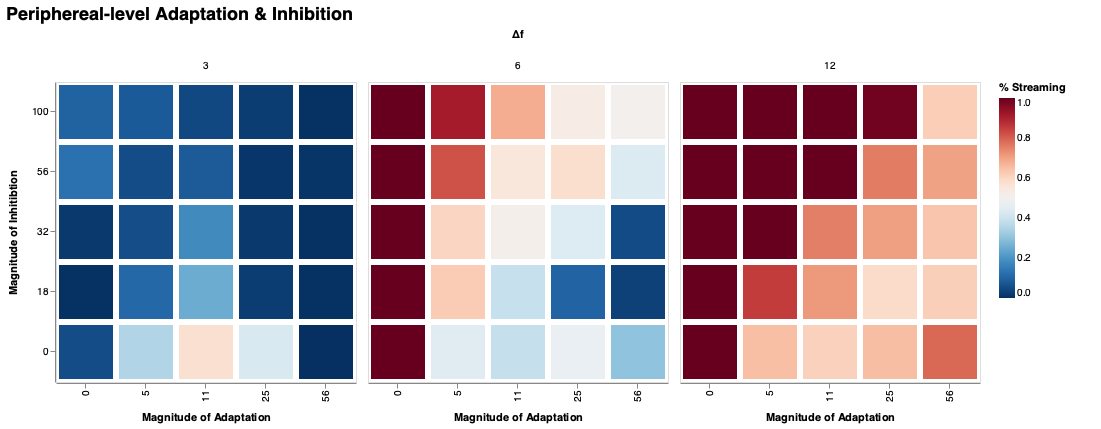

WARN column encoding should be discrete (ordinal / nominal / binned).


In [29]:
@where(df_summary,:f_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Periphereal-level Adaptation & Inhibition",fontSize=18},
          column=:Δf,
          x={field=:f_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:f_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="streamprop", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


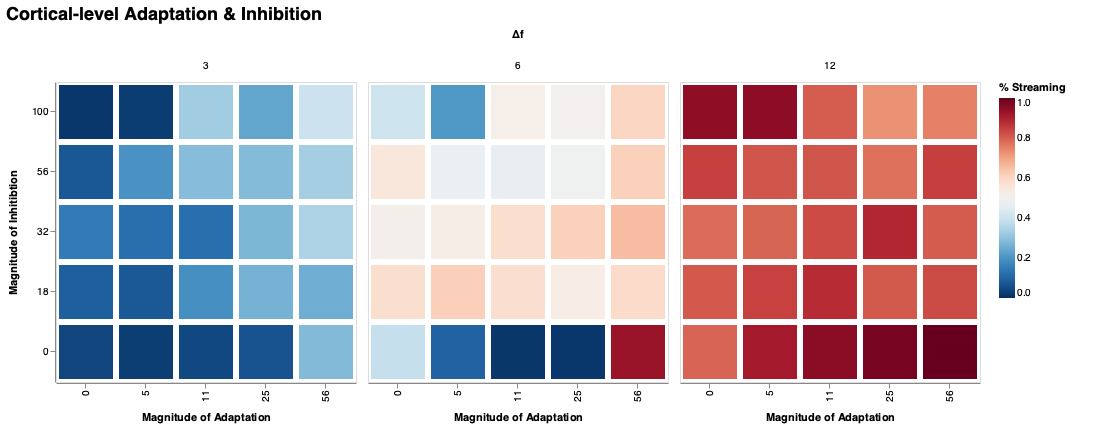

In [30]:
@where(df_summary,:s_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Cortical-level Adaptation & Inhibition",fontSize=18},
          column=:Δf,
          x={field=:s_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:s_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="streamprop", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


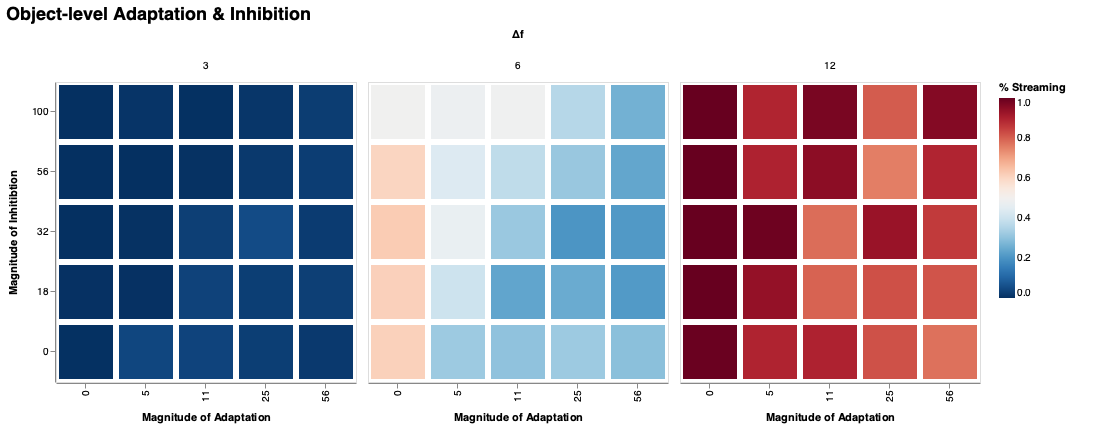

In [31]:
@where(df_summary,:t_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Object-level Adaptation & Inhibition",fontSize=18},
          column=:Δf,
          x={field=:t_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:t_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="streamprop", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

# RMS of streaming selectivity

In [34]:
mean_human = [0.11, 0.55, 0.89]
function stream_rms(str3,str6,str12)
  vec(sqrt.(mean((hcat(str3,str6,str12) .- mean_human').^2,dims=2)))
end

stream_rms (generic function with 1 method)

In [35]:
function rename_levels_for(df,val)
    df[:c_m] = NaN
    df[:c_a] = NaN
    df[:level] = "unknown"
    @byrow! df begin
        if :f_c_σ > 0 
           :level = "Peripheral"
            :c_m = :f_c_m
            :c_a = :f_c_a
        elseif :s_c_σ > 0 
            :level = "Cortical"
            :c_m = :s_c_m
            :c_a = :s_c_a
        elseif :t_c_σ > 0 
            :level = "Object"
            :c_m = :t_c_m
            :c_a = :t_c_a
        end
    end
    df[[:c_m,:c_a,:level,val]]
end
        
DataFramesMeta.linq(::DataFramesMeta.SymbolParameter{:rename_levels}, df, val) = :(rename_levels($df,$val))

In [36]:
df_stream_rms = @linq df_summary |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:Δf,:streamprop) |>
  unstack(:Δf,:streamprop) |>
  rename(Symbol("3") => :Δf_3,Symbol("6") => :Δf_6,Symbol("12") => :Δf_12) |>
  transform(stream_rms = stream_rms(:Δf_3,:Δf_6,:Δf_12)) |>
  rename_levels_for(:stream_rms)

,c_m,c_a,level,stream_rms
,Float64,Float64,String,Float64
1,0.0,0.0,Object,0.0951021
2,18.0,0.0,Object,0.0964246
3,32.0,0.0,Object,0.0996523
4,56.0,0.0,Object,0.0950509
5,100.0,0.0,Object,0.0953918
6,0.0,5.0,Object,0.138649
7,18.0,5.0,Object,0.110333
8,32.0,5.0,Object,0.0971972
9,56.0,5.0,Object,0.0917125


In [37]:
df_stim_rate |>
  @vlplot(:rect, width=300, height=300,
          title={text="Stimulus Rate",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field=:stim_rate, aggregate="mean", typ="quantitative", 
                 legend={title="Stimuli / Second"}},
          config={range={heatmap={scheme="viridis"}}})

UndefVarError: UndefVarError: df_stim_rate not defined

In [38]:
df_stream_rms2 = unstack(df_stream_rms,[:c_m,:c_a],:level,:stream_rms)

,c_m,c_a,Cortical,Object,Peripheral
,Float64,Float64,Float64⍰,Float64⍰,Float64⍰
1,0.0,0.0,0.117882,0.0951021,0.269466
2,0.0,5.0,0.266766,0.138649,0.205486
3,0.0,11.0,0.314433,0.150334,0.327354
4,0.0,25.0,0.315065,0.147135,0.232979
5,0.0,56.0,0.248762,0.170537,0.167525
6,18.0,0.0,0.051126,0.0964246,0.274528
7,18.0,5.0,0.050443,0.110333,0.0476284
8,18.0,11.0,0.0496931,0.19482,0.15939
9,18.0,25.0,0.101316,0.184905,0.317988


In [39]:
CSV.write("df_stream_test.csv",df_stream_rms2)

UndefVarError: UndefVarError: CSV not defined

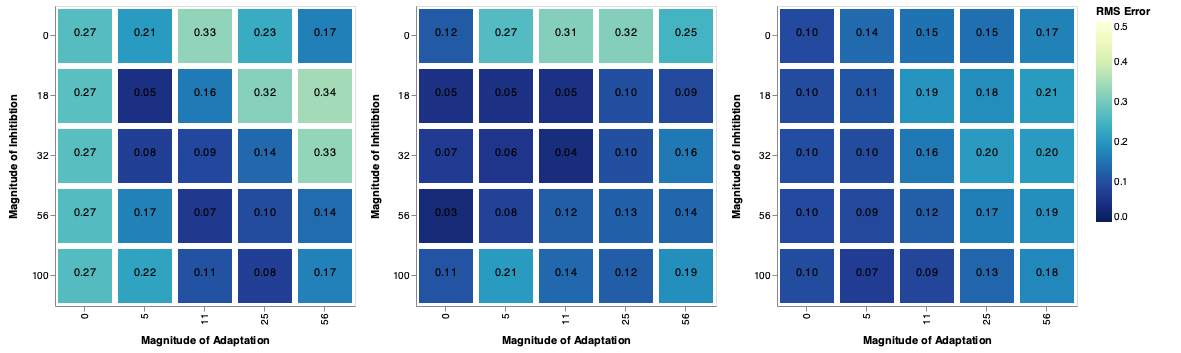

In [41]:
df_stream_rms2 |>
  @vlplot(repeat={column=["Peripheral","Cortical","Object"]},
    config={range={heatmap={scheme="yellowgreenblue"}}}) +
  (@vlplot() +
   @vlplot(:rect, width=300, height=300,
           x={field=:c_a, typ="ordinal", 
              axis={title="Magnitude of Adaptation"}},
           y={field=:c_m, typ="ordinal",
              axis={title="Magnitude of Inhitibtion"}},
           color={field={repeat="column"}, aggregate="mean", typ="quantitative", sort = "descending",
                  legend={title="RMS Error"}, scale={domain=[0,0.5]}}) +
   @vlplot(:text, width=300, height=300,
           x={field=:c_a, typ="ordinal", 
              axis={title="Magnitude of Adaptation"}},
           y={field=:c_m, typ="ordinal", 
              axis={title="Magnitude of Inhitibtion"}},
           text={field={repeat="column"}, aggregate="mean", typ="quantitative", format=".2f"}))

# Count

In [19]:
df_stim_rate = @linq df_summary |>
  where(:Δf .== 6) |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:stim_rate) |>
  rename_levels_for(:stim_rate);

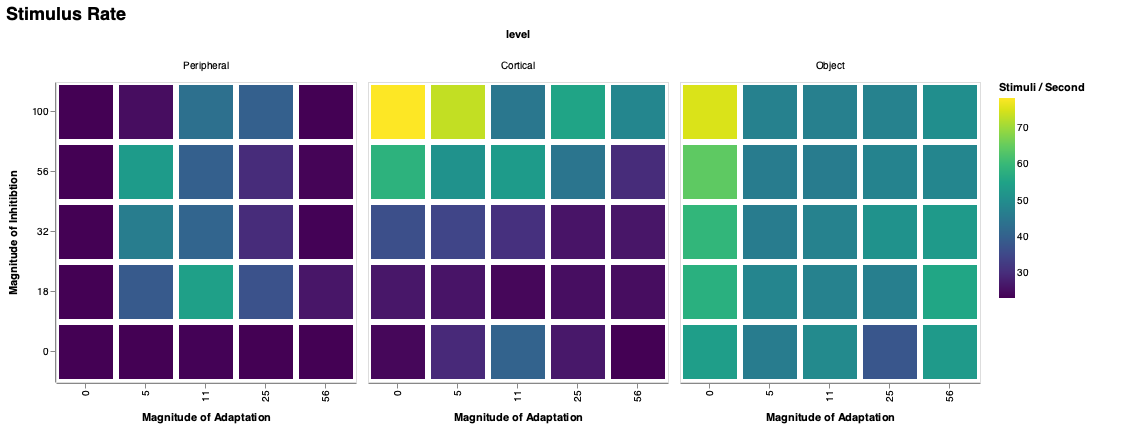

In [49]:
df_stim_rate |>
  @vlplot(:rect, width=300, height=300,
          title={text="Stimulus Rate",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field=:stim_rate, aggregate="mean", typ="quantitative", 
                 legend={title="Stimuli / Second"}},
          config={range={heatmap={scheme="viridis"}}})

# Log Normality

In [42]:
df_skew = @linq df_summary |>
  where(:Δf .== 6) |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:skew) |>
  rename_levels_for(:skew);

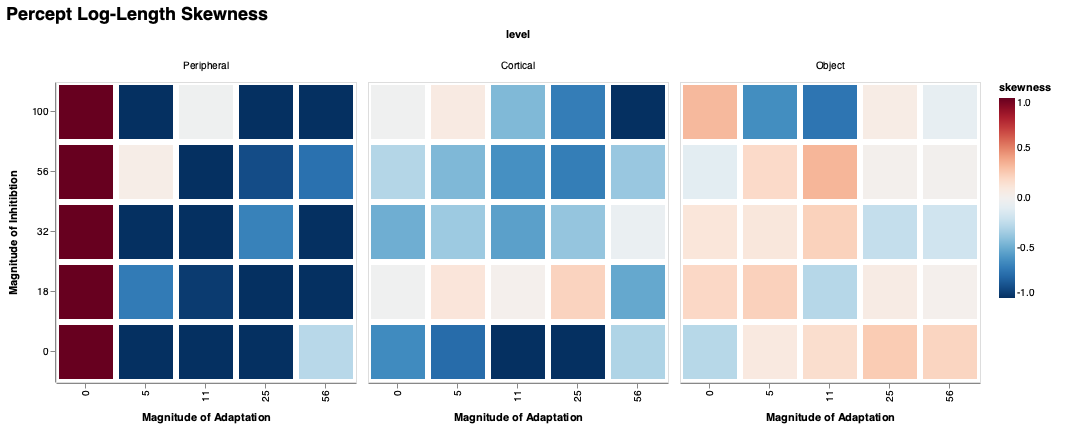

In [51]:
df_skew |>
  @vlplot(:rect, width=300, height=300,
          title={text="Percept Log-Length Skewness",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="skew", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[-1,1],range="diverging"},
                 legend={title="skewness"}},
          config={range={diverging={scheme="redblue"}}})

# Kurtosis

In [44]:
df_kurt = @linq df_summary |>
  where(:Δf .== 6) |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:kurt) |>
  rename_levels_for(:kurt);

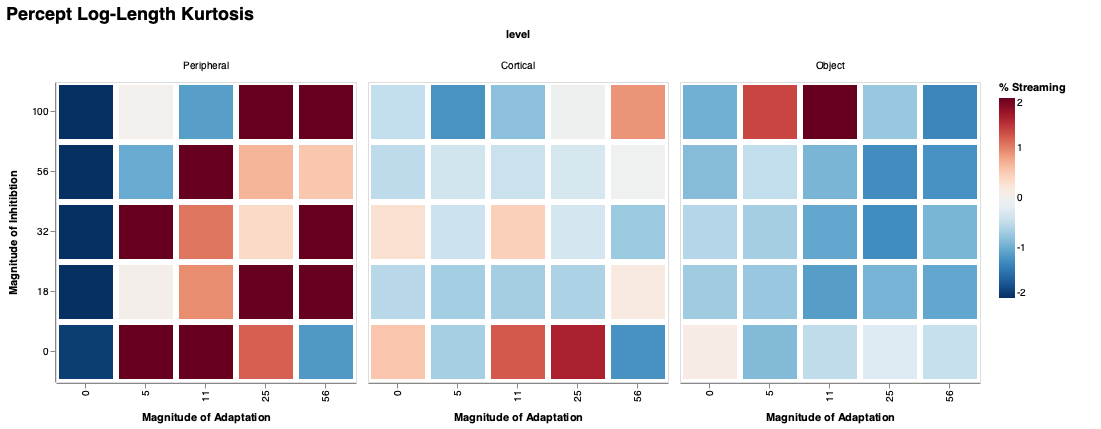

In [45]:
df_kurt |>
  @vlplot(:rect, width=300, height=300,
          title={text="Percept Log-Length Kurtosis",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="kurt", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[-2,2],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

I need to examine the distribution at 100 T_m, 11 T_a to see what's up with that distribution. Is it that the short trial time is making a large bar at 6.72 s?

# Overal RMS

In [46]:
rms(x) = any(isnan,x) ? 100 : sqrt(mean(x.^2))

rms (generic function with 1 method)

In [47]:
df_combined = join(df_stream_rms,df_skew,on = [:c_m,:c_a,:level])
df_combined = join(df_combined,df_kurt,on = [:c_m,:c_a,:level])

# for our purposes here we are going to say a kurtosis of 2, a skewness of 1, and a stream deviation of 0.5 are equivalent
# in the final analysis, we should z-score these statistics based on the human data
df_combined = @transform(df_combined,rms = vec(mapslices(rms,[:stream_rms./0.5 :skew./2 :kurt./2],dims=2)))

,c_m,c_a,level,stream_rms,skew,kurt,rms
,Float64,Float64,String,Float64,Float64,Float64,Float64
1,0.0,0.0,Object,0.0951021,-0.27841,0.127756,0.140992
2,18.0,0.0,Object,0.0964246,0.192875,-0.700605,0.237489
3,32.0,0.0,Object,0.0996523,0.113556,-0.575802,0.204803
4,56.0,0.0,Object,0.0950509,-0.0982633,-0.853316,0.271164
5,100.0,0.0,Object,0.0953918,0.324011,-0.967649,0.3145
6,0.0,5.0,Object,0.138649,0.088346,-0.876037,0.300391
7,18.0,5.0,Object,0.110333,0.22637,-0.746303,0.25868
8,32.0,5.0,Object,0.0971972,0.104374,-0.672801,0.226332
9,56.0,5.0,Object,0.0917125,0.181338,-0.478659,0.181791


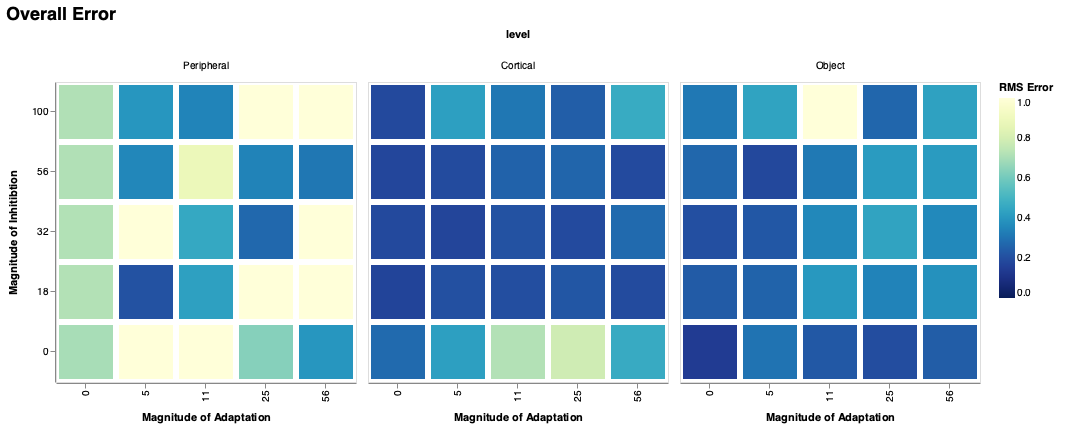

In [48]:
df_combined |>
  @vlplot(:rect, width=300, height=300,
          title={text="Overall Error",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="rms", aggregate="mean", typ="quantitative", sort="descending",
                 legend={title="RMS Error"}, scale={domain = [0,1]}},
          config={range={heatmap={scheme="yellowgreenblue"}},
                  invalidValues="filter"})

# individual trials

In [49]:
selection = @where(params,(abs.(:t_c_m .- 100) .< 1) .& (abs.(:t_c_a .- 11) .< 1) .& (:Δf .== 6))[:pindex][1]

198

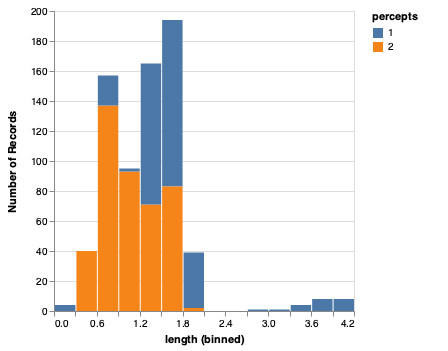

In [50]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.3}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [30]:
selection = @where(params,(abs.(:f_c_m .- 56) .< 1) .& (abs.(:f_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

34

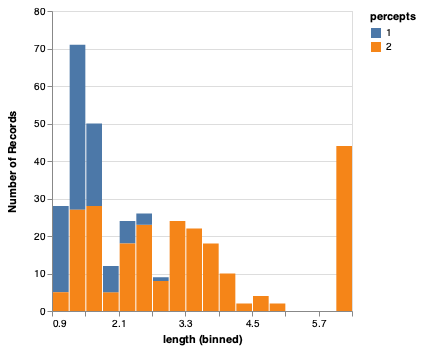

In [31]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.3}}, y="count()",
           color={field=:percepts, typ="nominal"})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


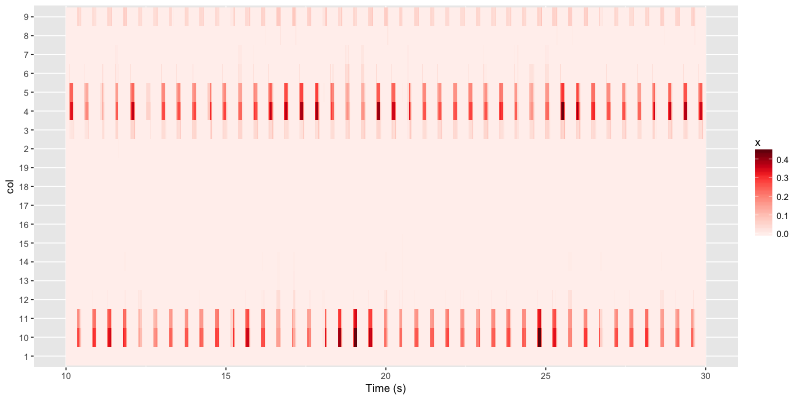

RObject{VecSxp}


In [150]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s])

In [32]:
selection = @where(params,(abs.(:f_c_m .- 18) .< 1) .& (abs.(:f_c_a .- 11) .< 1) .& (:Δf .== 6))[:pindex][1]

37

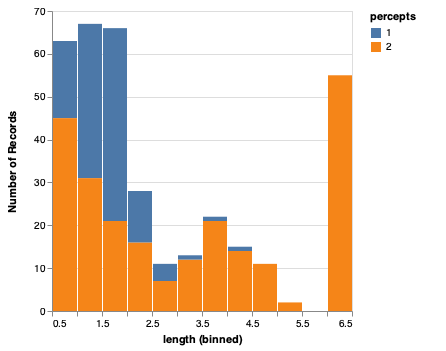

In [34]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()",
           color={field=:percepts, typ="nominal"})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


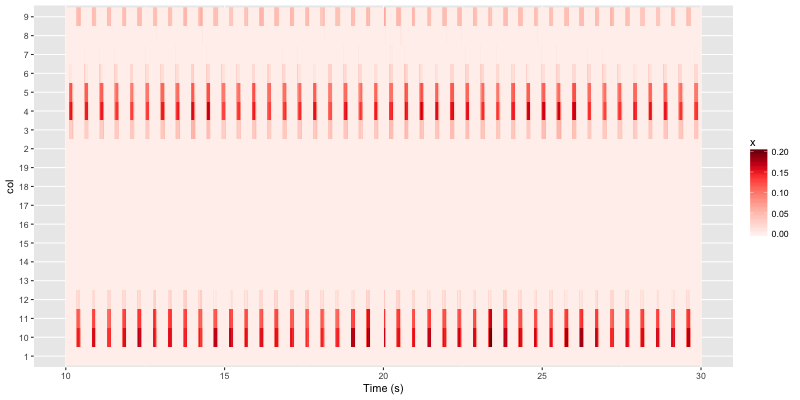

RObject{VecSxp}


In [155]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s])

In [156]:
selection = @where(params,(abs.(:f_c_m .- 100) .< 1) .& (abs.(:f_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

35

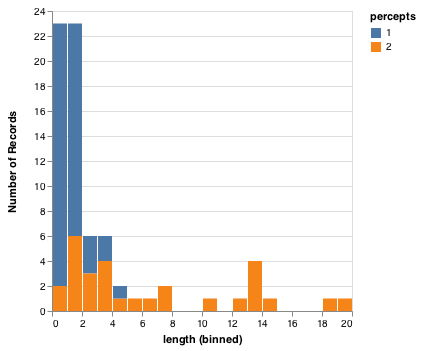

In [157]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=1.0}}, y="count()",
           color={field=:percepts, typ="nominal"})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


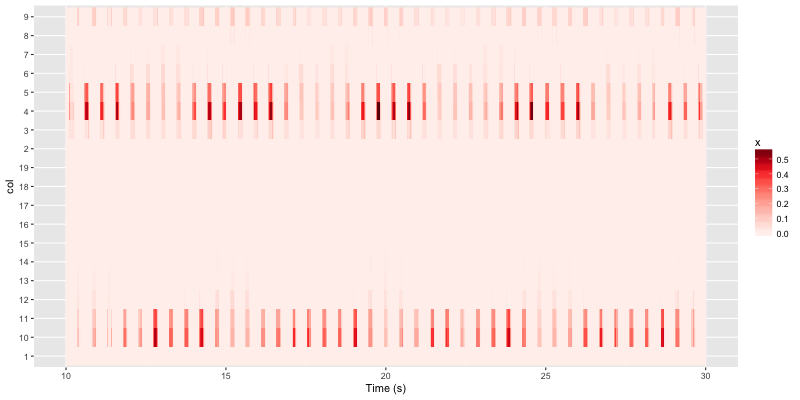

RObject{VecSxp}


In [158]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s])

In [35]:
selection = @where(params,(abs.(:s_c_m .- 56) .< 1) .& (abs.(:s_c_a .- 11) .< 1) .& (:Δf .== 6))[:pindex][1]

114

WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


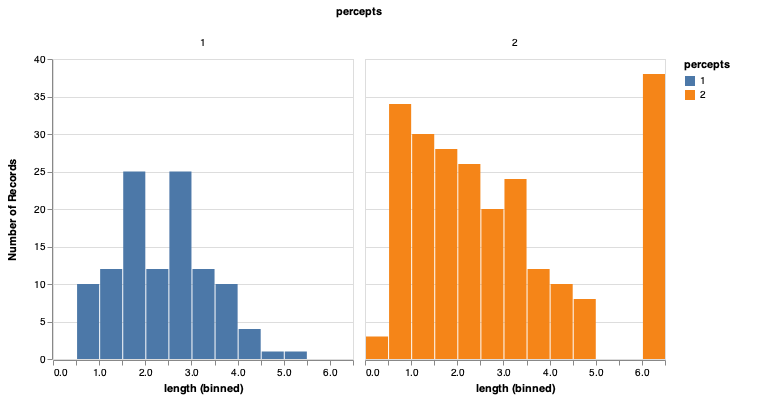

In [39]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()", column=:percepts,
           color={field=:percepts, typ="nominal"})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


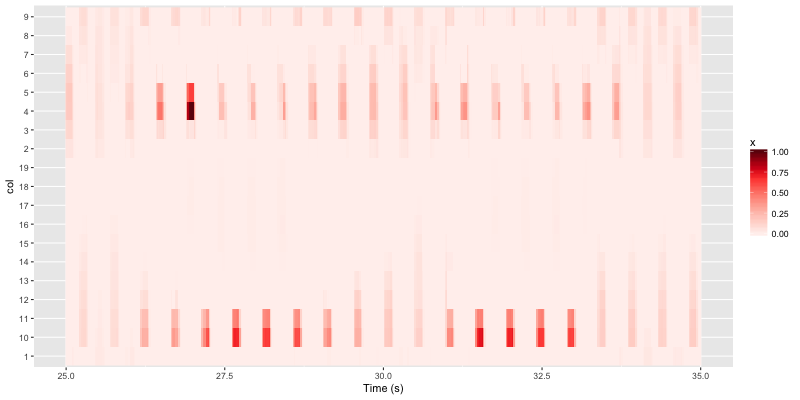

RObject{VecSxp}


In [161]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s])

In [162]:
selection = @where(params,(abs.(:s_c_m .- 56) .< 1) .& (abs.(:s_c_a .- 25) .< 1) .& (:Δf .== 6))[:pindex][1]

119

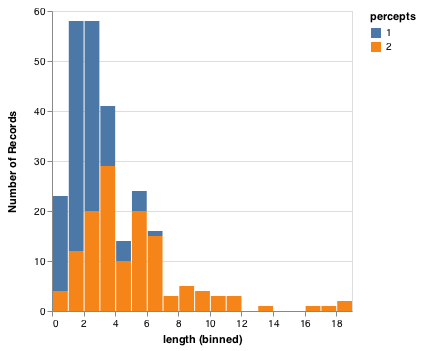

In [163]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=1.0}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [38]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


ArgumentError: ArgumentError: collection must be non-empty

In [15]:
selection = @where(params,(abs.(:t_c_m .- 18) .< 1) .& (abs.(:t_c_a .- 56) .< 1) .& (:Δf .== 6))[:pindex][1]

185

In [22]:
@where(df,(:pindex .== selection) .& (:length .< 20))

,length,percepts,created,pindex
,Float64,Bool,DateTime,Int64
1,2.6,false,2018-11-10T19:18:24.768,185
2,0.6,true,2018-11-10T19:18:24.768,185
3,2.3,false,2018-11-10T19:18:24.768,185
4,0.5,true,2018-11-10T19:18:24.768,185
5,1.2,false,2018-11-10T19:18:25.514,185
6,0.6,true,2018-11-10T19:18:25.514,185
7,2.7,false,2018-11-10T19:18:25.514,185
8,1.5,true,2018-11-10T19:18:25.514,185
9,1.8,false,2018-11-10T19:18:26.298,185


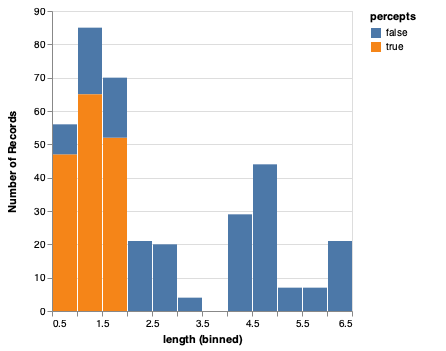

In [16]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()",
           color={field=:percepts, typ="nominal"})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


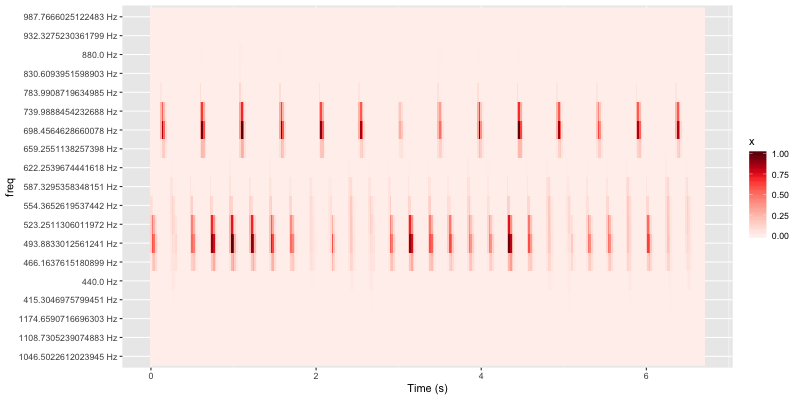

RObject{VecSxp}


In [17]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1]))

In [18]:
@where(df,:pindex .== selection)

,length,percepts,created,pindex
,Float64,Bool,DateTime,Int64
1,2.6,false,2018-11-10T19:18:24.768,185
2,0.6,true,2018-11-10T19:18:24.768,185
3,2.3,false,2018-11-10T19:18:24.768,185
4,0.5,true,2018-11-10T19:18:24.768,185
5,1.2,false,2018-11-10T19:18:25.514,185
6,0.6,true,2018-11-10T19:18:25.514,185
7,2.7,false,2018-11-10T19:18:25.514,185
8,1.5,true,2018-11-10T19:18:25.514,185
9,1.8,false,2018-11-10T19:18:26.298,185


In [19]:
selection = @where(params,(abs.(:t_c_m .- 18) .< 1) .& (abs.(:t_c_a .- 56) .< 1) .& (:Δf .== 6))[:pindex][1]

185

In [ ]:
# NEXT STEP: get new bandwidth_ratio parameters working, and test them out

In [20]:
params_dict = Dict(k => params[selection,k] for k in names(params))
result = bistable_model(35,params_dict,joinpath("..","src","settings.toml"),interactive=true);

MethodError: MethodError: no method matching audiospect_stimulus(::NamedTuple{(:percept_lengths, :freqs, :mask, :rates, :scales, :stimulus, :track, :nmf, :bandwidth_ratio),Tuple{NamedTuple{(:threshold, :min_length_ms),Tuple{Float64,Int64}},NamedTuple{(:bistable, :analyze),Tuple{NamedTuple{(:lowpass, :lowpass_order, :input_bound),Tuple{Float64,Int64,Array{Float64,1}}},NamedTuple{(:delta_t_ms, :freq_step),Tuple{Int64,Int64}}}},NamedTuple{(:window_ms, :delta_ms),Tuple{Int64,Int64}},NamedTuple{(:rates_Hz, :bandonly, :freq_limits_Hz),Tuple{Array{Int64,1},Bool,Array{Float64,1}}},NamedTuple{(:bistable, :analyze),Tuple{NamedTuple{(:lowpass, :lowpass_order, :input_bound),Tuple{Float64,Int64,Array{Float64,1}}},NamedTuple{(:scales_cycoct, :bandonly),Tuple{Array{Float64,1},Bool}}}},NamedTuple{(:ramp_len_ms, :pattern, :tone_len_fraction),Tuple{Int64,String,Float64}},NamedTuple{(:bistable, :analyze),Tuple{NamedTuple{(:lowpass, :lowpass_order, :input_bound, :normalize_start_s),Tuple{Float64,Int64,Array{Float64,1},Float64}},NamedTuple{(:source_prior_strengths_s, :scale_ridge, :normalize, :time_constants_s, :max_sources, :freq_ridge, :source_prior_sds, :freq_prior_bias, :min_norm, :freq_prior_N),Tuple{Array{Int64,1},Float64,Bool,Array{Float64,1},Int64,Float64,Array{Float64,1},Int64,Float64,Int64}}}},NamedTuple{(:skipframes, :tol, :window_ms, :ncomponents, :maxiter, :delta_ms),Tuple{Int64,Float64,Int64,Int64,Int64,Int64}},NamedTuple{(:window_ms, :full_band_ratio, :threshold, :level_threshold, :delta_ms, :thresh_ratio),Tuple{Int64,Int64,Float64,Float64,Int64,Float64}}}}, ::Dict{Symbol,Number}; cache=true)
Closest candidates are:
  audiospect_stimulus(::Any, ::Any, !Matched::Any; cache) at /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:30

In [7]:
result.percepts.counts

([3.6, 3.6, 8.3, 0.6], Bool[false, true, false, true])

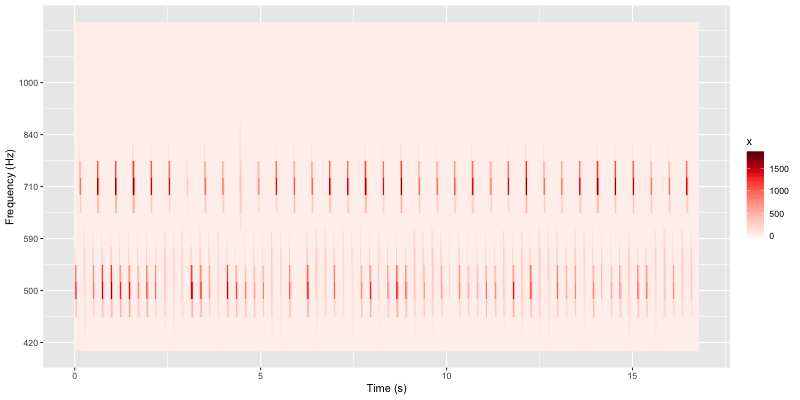

RObject{VecSxp}


In [8]:
rplot(result.primary_source)

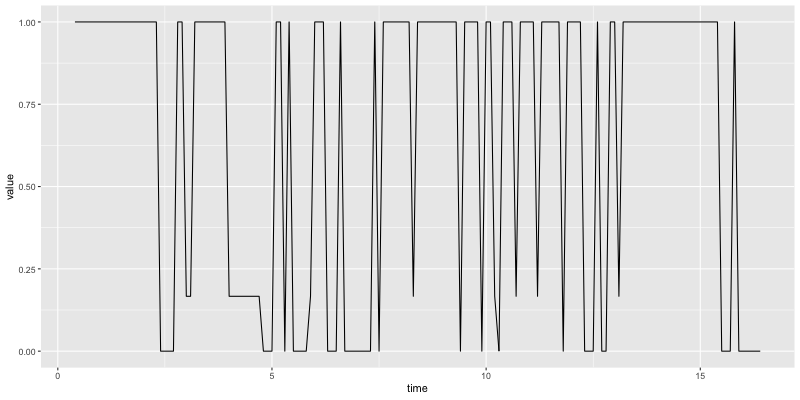

RObject{VecSxp}


In [9]:
rplot(result.percepts.ratio)

In [72]:
freqs(result.input[:,400Hz .. 1.2kHz])

19-element Array{Quantity{Float64,Unitful.Dimensions{(Unitful.Dimension{:Time}(-1//1),)},Unitful.FreeUnits{(Unitful.Unit{:Hertz,Unitful.Dimensions{(Unitful.Dimension{:Time}(-1//1),)}}(0, 1//1),),Unitful.Dimensions{(Unitful.Dimension{:Time}(-1//1),)}}},1}:
  415.3046975799451 Hz
              440.0 Hz
  466.1637615180899 Hz
  493.8833012561241 Hz
  523.2511306011972 Hz
  554.3652619537442 Hz
  587.3295358348151 Hz
  622.2539674441618 Hz
  659.2551138257398 Hz
  698.4564628660078 Hz
  739.9888454232688 Hz
  783.9908719634985 Hz
  830.6093951598903 Hz
              880.0 Hz
  932.3275230361799 Hz
  987.7666025122483 Hz
 1046.5022612023945 Hz
 1108.7305239074883 Hz
 1174.6590716696303 Hz

In [62]:
params_dict = Dict(k => params[selection,k] for k in names(params))
params_dict[:Δf] = 3
result = bistable_model(35,params_dict,joinpath("..","src","settings.toml"),interactive=true);

Temporal Coherence Analysis: 100%|██████████████████████| Time: 0:00:01
┌ Info: 0.6% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:45
Source Tracking (multi-prior):  84%|█████████████████   |  ETA: 0:00:00

fullchan


Source Tracking (multi-prior): 100%|████████████████████| Time: 0:00:01


maskchan


In [64]:
result.percepts.counts

([10.2, 0.7, 5.2], Bool[false, true, false])

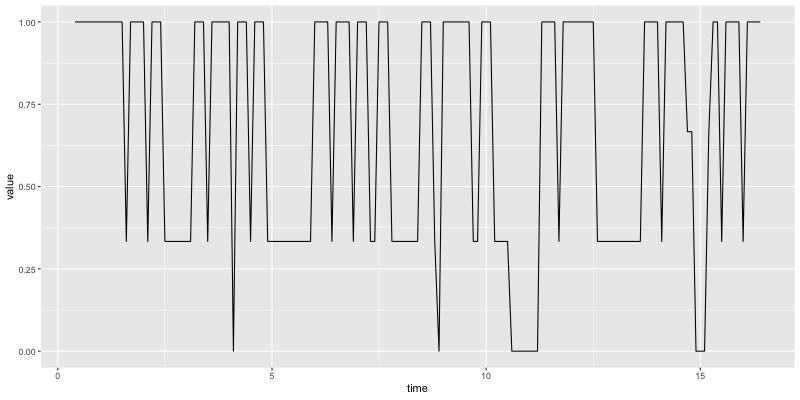

RObject{VecSxp}


In [63]:
rplot(result.percepts.ratio)

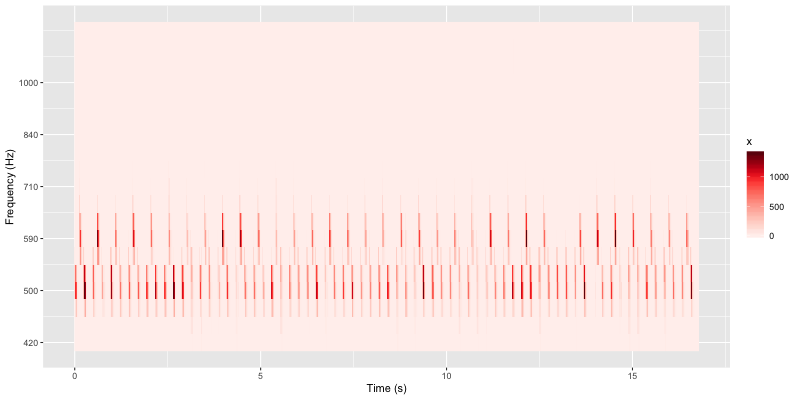

RObject{VecSxp}


In [65]:
rplot(result.primary_source)

In [66]:
params_dict = Dict(k => params[selection,k] for k in names(params))
params_dict[:Δf] = 12
result = bistable_model(35,params_dict,joinpath("..","src","settings.toml"),interactive=true);

Cortical Model: 100%|███████████████████████████████████| Time: 0:00:00
Temporal Coherence Analysis: 100%|██████████████████████| Time: 0:00:00
Source Tracking (multi-prior):  85%|█████████████████   |  ETA: 0:00:00

fullchan


Source Tracking (multi-prior): 100%|████████████████████| Time: 0:00:01


maskchan


In [69]:
result.percepts.counts

([1.1, 2.6, 0.8, 7.9, 0.8, 2.9], Bool[false, true, false, true, false, true])

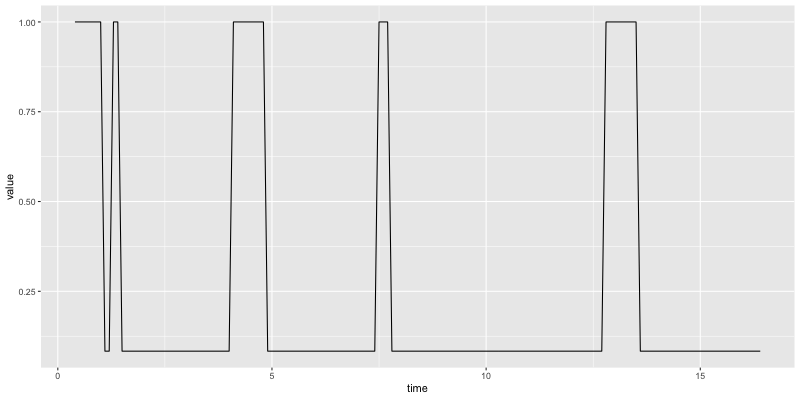

RObject{VecSxp}


In [67]:
rplot(result.percepts.ratio)

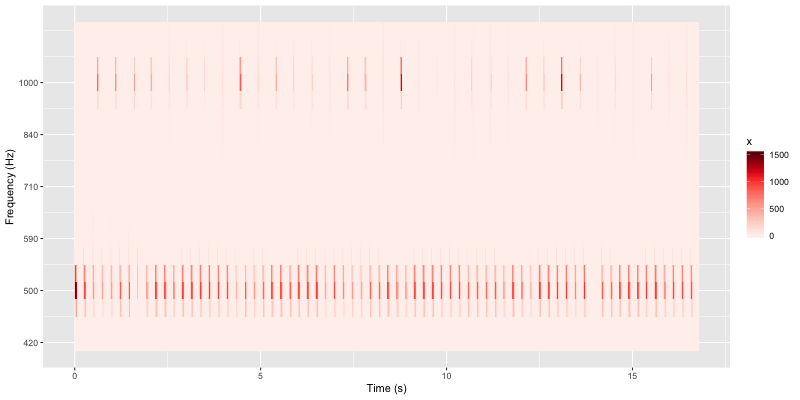

RObject{VecSxp}


In [68]:
rplot(result.primary_source)